### Problem Statement

Data.gov is a U.S. government website launched in late May 2009 by the then Federal Chief Information Officer (CIO) of the United States. Data.gov aims to improve public access to high value, machine readable datasets generated by the Executive Branch of the Federal Government. With the advent of modern Data Science, it is worth exploring it to check the value it can yield in the world of investing.

The task for you is to apply modern Data Science techniques to Allegheny County Property Assessments Dataset from Data.gov, with the purpose of identifying how this dataset could generate valuable insights for investing. We anticipate that candidates could use concepts from probability theory, model selection, model validation and optimization techniques, and other Data Science methods. Below are a few potential avenues for you to show off your Data Science skills, but the case study is open ended. Feel free to jump in and see where the data leads you!

Q1:	Is housing price in Allegheny county a martingale? Provide your answer using both a conceptual explanation and an empirical explanation using the case study dataset.

Q2:	Design and test a simple monthly "Allegheny County Home Value Index" using the case study dataset. As an example, see a methodology for a home value index described here.

Q3:	Using the case study dataset, design and test an investment strategy. Let the initial budget for your strategy be $5 million. Let the objective of your strategy be to maximize the value of your budgeted amount at investment time horizon by buying homes that appear on the market in Allegheny county starting January 1, 2016. Let the time horizon to check the resulting value of your investments be November 30, 2020. Use the case study dataset up until and including year 2015 for training and development, and test the developed strategy starting at year 2016. As needed, specify any additional assumptions for the analysis.

In [1]:
# Import primary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
import os
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import inf
from pandas.tseries.offsets import MonthEnd
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
warnings.filterwarnings("ignore")
plt.style.use('bmh')

path = r'C:/Projects/Fidelity/data'

register_matplotlib_converters()

In [2]:
# Generic utility functions 

def winsorize_df (data, wins_limits=[0.01,0.01]):  
    """
    This function windsorizes a dataframe rowwise
    """
    data_norm = np.where(data.isnull(), np.nan,
                             scipy.stats.mstats.winsorize(np.ma.masked_invalid(data), limits=wins_limits, axis=0))
    data = pd.DataFrame(data_norm, index=data.index, columns=data.columns)
    return data

def winsorize_series (data, wins_limits=[0.01,0.01]):    
    """
    This function windsorizes a series
    """
    data_norm = np.where(data.isnull(), np.nan,
                             scipy.stats.mstats.winsorize(np.ma.masked_invalid(data), limits=wins_limits, axis=0))
    return data_norm

def zscore_series (data, clip_limits=[-3,3]):    
    """
    This function transforms data series into a zscore (bell curve)
    """
    data_norm = (data - np.mean(data))/np.std(data)
    data_norm = data_norm.clip(-3,3)
    return data_norm

def percentiles(input_vec: pd.Series, inclusive: bool = True) -> pd.Series:
    """
    This function will return percentile values for a row of data.
    It will ignore NaN values. Best used using apply by row on a matrix
    """

    pct_vec = input_vec.copy()

    input_arr = input_vec.to_numpy()
    non_nan = ~np.isnan(input_arr)
    non_nan_count = np.sum(non_nan)

    if non_nan_count <= 1:
        pct_vec[non_nan] = .5
    else:
        syn_pct = np.linspace(0, 1, non_nan_count)
        non_nan_values = input_arr[non_nan]

        # Assign the vector to sorted values
        index = non_nan.nonzero()[0][np.argsort(non_nan_values)]

        if inclusive:
            pct_vec.iloc[index] = syn_pct
        else:
            pct_vec.iloc[index] = np.arange(1, len(index)+1) / (non_nan_count+1)

    return pct_vec

def create_home_value_index(data_df):
    """
    This function creates home value index.
    1. Aggregates sale price at a monthly level and compute the appreciation
    2. It also uses the STL algorithm to detrend the data. 
    3. Finally computes a rolling 3 month average of the index and further smooths it.
    
    """

    median_px_appreciation = data_df.groupby('mdate')['SALEPRICE_clean'].mean().pct_change(1).fillna(0)
    stl = STL((median_px_appreciation+1).cumprod(), seasonal=13, robust = True, period = 13)
    res = stl.fit()
    index = res.trend
    index = index.rolling(3).mean()
    return index

def house_buying_engine(house_df,buy_score, score_column):
    """
    Primary function to simulate a home buying engine. 
    1. Aggreagte the dates to iterate upon
    2. Check if any already held houses are up for sale. If yes, sell them.
    3. Check if there are any houses in the market which can be bought and if we have capital. If yes, buy some houses!
    
    """
    date_list = np.sort(list(set(list(house_df.pmdate.unique()) + list(house_df.mdate.unique()))))
    invest_df = pd.DataFrame(0, index = date_list, columns = ['houses_bought','houses_sold','capital_invested','capital_redeemed','pnl_booked','capital_remaining', 'NAV'])
    capital_left = 5_000_000
    invested_house_codes = []
    NAV = 5_000_000

    for idate in invest_df.index:

        ihouses_bought = 0
        ihouses_sold = 0
        icap_invested = 0
        icap_redeemed = 0
        ipnl_booked = 0

        ihouses = house_df.loc[house_df.mdate==idate,:]

        if len(ihouses)>0:
            for idx in ihouses.index:
                parid = ihouses.loc[idx,'PARID']
                if parid in invested_house_codes:
                    isale_px = ihouses.loc[idx,'SALEPRICE_clean']
                    ipnl = ihouses.loc[idx,'house_pnl']

                    ihouses_sold+=1
                    icap_redeemed+=isale_px
                    capital_left+=isale_px
                    ipnl_booked+=ipnl
                    NAV+=ipnl
                    invested_house_codes.remove(parid)

        jhouses = house_df.loc[(house_df.pmdate==idate)&(house_df[score_column]>=buy_score),:]
        jhouses = jhouses.sort_values(by=score_column,ascending = False)

        if len(jhouses)>0:
            for idx in jhouses.index:
                isale_px = jhouses.loc[idx,'PREVSALEPRICE_clean']
                if isale_px <= capital_left:
                    ihouses_bought+=1
                    icap_invested+=isale_px
                    capital_left-=isale_px
                    invested_house_codes.append(jhouses.loc[idx,'PARID'])

        invest_df.loc[idate,:] = [ihouses_bought,ihouses_sold,icap_invested,icap_redeemed,ipnl_booked,capital_left,NAV]
    return invest_df, invested_house_codes

### Import data
We start with importing the data and walkthrough the column names, data times etc.

In [3]:
df = pd.read_csv(path+'/assessments.csv', low_memory=False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581123 entries, 0 to 581122
Data columns (total 86 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PARID                 581123 non-null  object 
 1   PROPERTYHOUSENUM      581097 non-null  float64
 2   PROPERTYFRACTION      581123 non-null  object 
 3   PROPERTYADDRESS       581123 non-null  object 
 4   PROPERTYCITY          581101 non-null  object 
 5   PROPERTYSTATE         581123 non-null  object 
 6   PROPERTYUNIT          581123 non-null  object 
 7   PROPERTYZIP           581102 non-null  float64
 8   MUNICODE              581123 non-null  int64  
 9   MUNIDESC              581123 non-null  object 
 10  SCHOOLCODE            581123 non-null  int64  
 11  SCHOOLDESC            581123 non-null  object 
 12  LEGAL1                581101 non-null  object 
 13  LEGAL2                517225 non-null  object 
 14  LEGAL3                337815 non-null  object 
 15  

### Filter houses depending on type, owners etc.
Now filter the houses based on house types (CLASS), usage type (USEDESC), and owner type (OWNERDESC). This basically filters the houses to select the most relevant ones for our analysis.

1. Because the assigment deals only with home prices, we filter out the non-home data first. For this we can use the CLASS field and filter only for 'R' categories. We first check that the class categories does not have any null values. We also show the value counts for this and notice that most of the listings are for Residentials

2. Next we look at the USEDESC and subset for the residential uses such as single-family, condominium etc.

3. Similar to above, now we look at OWNERDESC and only select the REGULAR onwers and filter out CORPORATES etc. This is done because we are looking at housing prices and CORPORATE owned units could be sold at non-market prices due to distress etc.

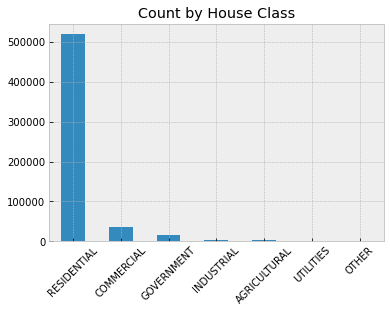

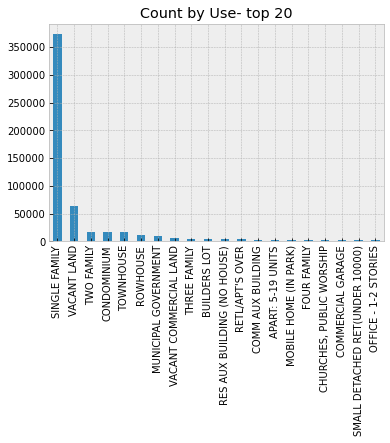

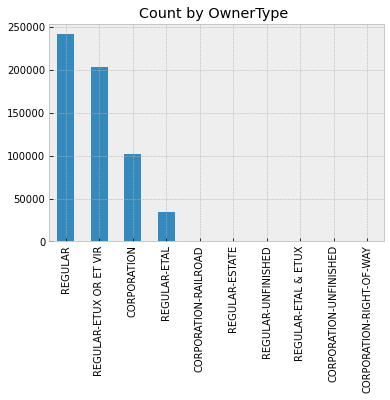

In [4]:
df['CLASSDESC'].value_counts().plot.bar()
plt.title('Count by House Class')
plt.xticks(rotation=45)
plt.show()

df['USEDESC'].value_counts().head(20).plot.bar()
plt.title('Count by Use- top 20')
plt.show()

df['OWNERDESC'].value_counts().plot.bar()
plt.title('Count by OwnerType ')
plt.show()

In [5]:
# CLASS Filter
print(df['CLASS'].isna().sum())
print(df['CLASS'].value_counts())
df = df[df.CLASS=='R']
print('\n')

# USEDESC Filter
print(df['USEDESC'].value_counts())
residential_list = ['SINGLE FAMILY','TWO FAMILY','CONDOMINIUM','TOWNHOUSE','ROWHOUSE','THREE FAMILY']                        
mask = [True if x in residential_list else False for x in df['USEDESC']]
df = df.loc[mask,:]
print(df['USEDESC'].value_counts())
print('\n')

# OWNERDESC Filter
print(df['OWNERDESC'].isna().sum())
print(df['OWNERDESC'].value_counts())
mask = [True if 'REGULAR' in x else False for x in df['OWNERDESC']]
df = df.loc[mask,:]
print(df['OWNERDESC'].value_counts())
print('\n')

0
R    519224
C     36246
G     16846
I      3675
F      2398
U      1955
O       779
Name: CLASS, dtype: int64


SINGLE FAMILY                     373231
VACANT LAND                        64167
TWO FAMILY                         17377
CONDOMINIUM                        17064
TOWNHOUSE                          16062
ROWHOUSE                           11221
THREE FAMILY                        3979
BUILDERS LOT                        3668
RES AUX BUILDING (NO HOUSE)         3621
MOBILE HOME (IN PARK)               2793
FOUR FAMILY                         2055
CONDOMINIUM COMMON PROPERTY         1335
MOBILE HOME                          679
RIGHT OF WAY - RESIDENTIAL           601
CONDO GARAGE UNITS                   377
CONDO DEVELOPMENTAL LAND             308
COMMON AREA                          255
CONDEMNED/BOARDED-UP                 179
RETENTION POND - RESIDENTIAL         121
MUNICIPAL GOVERNMENT                  40
COAL RIGHTS, WORKING INTERESTS        27
TOTAL/MAJOR FIRE DAMAGE  

### Cleaning Dates

 - Given we have individual sale prices of houses, we can aggregate at monthly level and use average or median to get a house price value.
 - For this we start with cleaning the dates. We convert the SALEDATE and PREVSALEDATE to month end values and add two new columns 'mdate' and 'pmdate'.
 - We also find that there are some null values in dates which we drop. 
 - Further we subset the universe to more recent 20 years data.

In [6]:
print('Number of Nans in SALEDATE:' + str(df['SALEDATE'].isna().sum()))

# Convert to month end dates
df['date'] = pd.to_datetime(df['SALEDATE'], errors='coerce')
df['mdate']= pd.to_datetime(df.date, format="%Y%m") + MonthEnd(0)
df['pdate'] = pd.to_datetime(df['PREVSALEDATE'], errors='coerce')
df['pmdate']= pd.to_datetime(df.pdate, format="%Y%m") + MonthEnd(0)

# Drop nan dates

df = df[~df.mdate.isna()]
df = df[~df.pmdate.isna()]

# Subset to use data between 2000 and 2020

df2 = df.loc[(df.date>='2000-01-01') & (df.date<'2021-01-01') ,:]

Number of Nans in SALEDATE:427


### House sale counts
We start with analyzing how many houses are sold per month and some breakdown of them by characteristics such as use descriptions, year built, # of rooms, # of bathrooms etc.

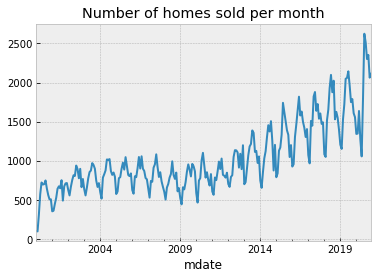

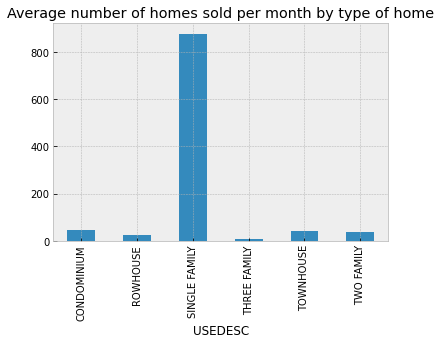

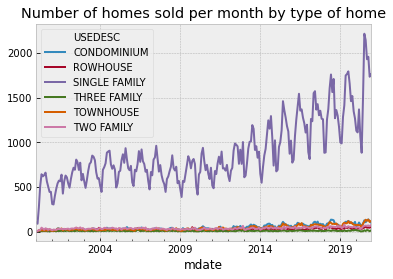

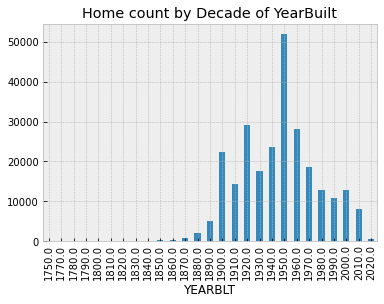

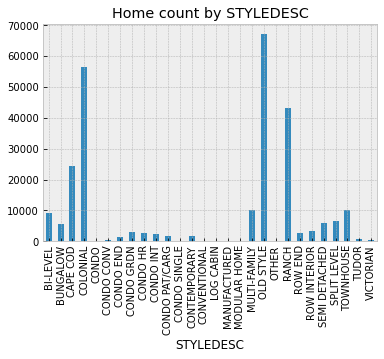

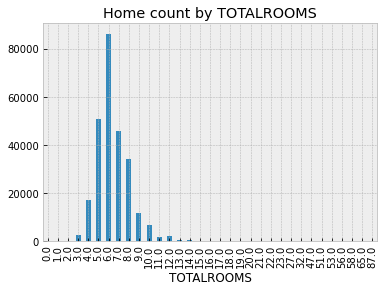

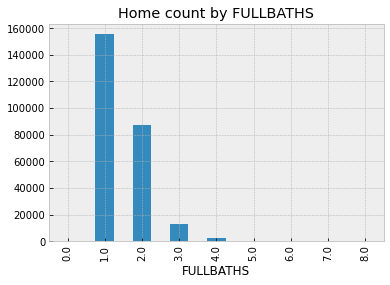

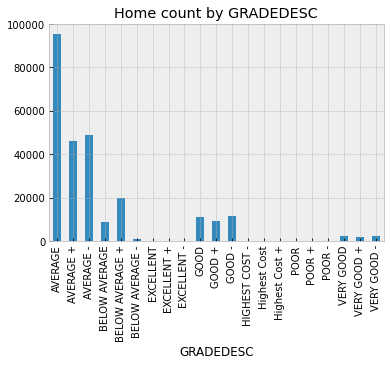

In [7]:
df2.groupby('mdate')['PARID'].count().plot()
plt.title('Number of homes sold per month')
plt.show()

df2.groupby(['mdate','USEDESC'])['SALEPRICE'].count().unstack().mean().plot.bar()
plt.title('Average number of homes sold per month by type of home')
plt.show()

df2.groupby(['mdate','USEDESC'])['SALEPRICE'].count().unstack().plot()
plt.title('Number of homes sold per month by type of home')
plt.show()

df2.groupby((df2.YEARBLT//10)*10)['SALEPRICE'].count().plot.bar()
plt.title('Home count by Decade of YearBuilt')
plt.show()

df2.groupby(['STYLEDESC'])['SALEPRICE'].count().plot.bar()
plt.title('Home count by STYLEDESC')
plt.show()

df2.groupby(['TOTALROOMS'])['SALEPRICE'].count().plot.bar()
plt.title('Home count by TOTALROOMS')
plt.show()

df2.groupby(['FULLBATHS'])['SALEPRICE'].count().plot.bar()
plt.title('Home count by FULLBATHS')
plt.show()

df2.groupby(['GRADEDESC'])['SALEPRICE'].count().plot.bar()
plt.title('Home count by GRADEDESC')
plt.show()



### Home prices
 - Next we analyze the cross section and time series of prices. 
 - Look for outliers and fix them.
 - Looking at the distribution of prices we initially find a lot of outliers. So we winsorize them on both ends at 1%. 
 - We still find a lot of outliers on the left end and value_count shows that there are a lot of homes with SALEPRICE = 0 or 1.

0.0            9398
1.0           51020
2.0              11
3.0               4
4.0               1
              ...  
5000000.0         1
10092014.0        1
10662000.0        1
11022000.0        1
71200000.0        1
Name: SALEPRICE, Length: 17847, dtype: int64


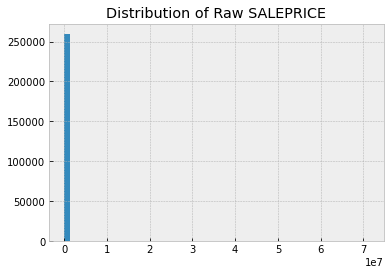

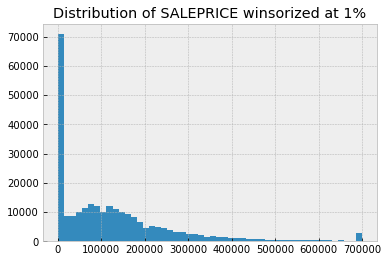

In [8]:
print(df2.SALEPRICE.value_counts().sort_index())

df2.SALEPRICE.hist(bins=50)
plt.title('Distribution of Raw SALEPRICE')
plt.show()

pd.Series(winsorize_series(df2.SALEPRICE, wins_limits = [0.01,0.01])).hist(bins=50)
plt.title('Distribution of SALEPRICE winsorized at 1%')
plt.show()

### Home price cleaning
 - In the next few steps we look at the actual underlying data where the saleprice is 0 or 1 and then look at the public websites such as zillow to gather more information.
 - In our spot checks we found that anywhere the price is 0 or 1, zillow does not seem to have a record of that sale. We have included some screenshots from zillow below.

In [9]:
df2.loc[df2.SALEPRICE < 10, ['PROPERTYHOUSENUM','PROPERTYADDRESS','PROPERTYCITY','PROPERTYUNIT','SALEPRICE','SALEDATE','PREVSALEPRICE','PREVSALEDATE']]

,PROPERTYHOUSENUM,PROPERTYADDRESS,PROPERTYCITY,PROPERTYUNIT,SALEPRICE,SALEDATE,PREVSALEPRICE,PREVSALEDATE
30,151.0,FORT PITT BLVD,PITTSBURGH,UNIT 702,1.0,04-27-2020,295000.0,09-02-2008
194,306.0,4TH AVE,PITTSBURGH,UNIT 302,1.0,02-08-2018,276377.0,11-02-2009
436,429.0,1ST AVE,PITTSBURGH,,1.0,12-31-2001,1.0,12-28-2001
611,1.0,MARION ST,PITTSBURGH,,0.0,04-17-2014,0.0,09-30-1970
657,117.0,VAN BRAAM ST,PITTSBURGH,,0.0,04-20-2010,10000.0,05-26-1994
...,...,...,...,...,...,...,...,...
581060,236.0,CARYL DR,PITTSBURGH,,1.0,04-29-2005,92850.0,10-31-1997
581068,4860.0,ELMWOOD DR,PITTSBURGH,,1.0,05-29-2012,79000.0,03-24-1993
581079,1519.0,KING JOHN DR,PITTSBURGH,,1.0,05-14-2004,105000.0,10-11-1988
581091,1742.0,HEATHER HEIGHTS DR,CRESCENT,,1.0,12-10-2007,172694.0,10-01-2002


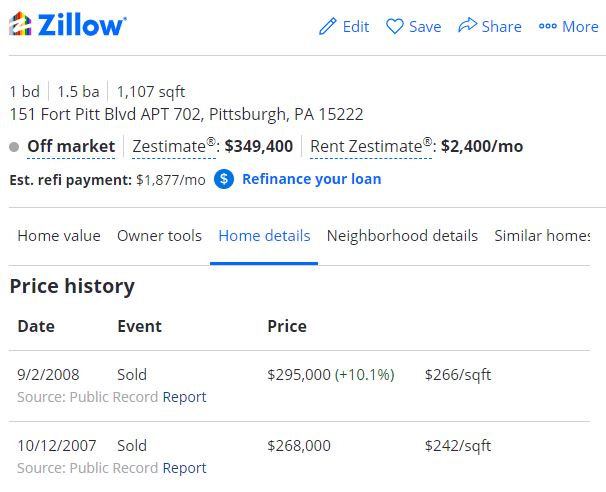

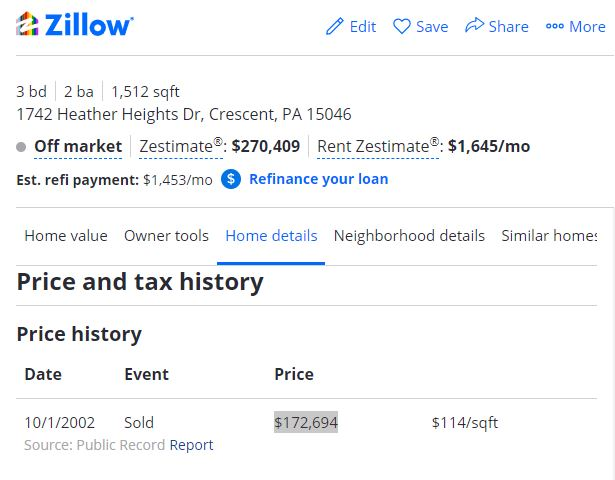

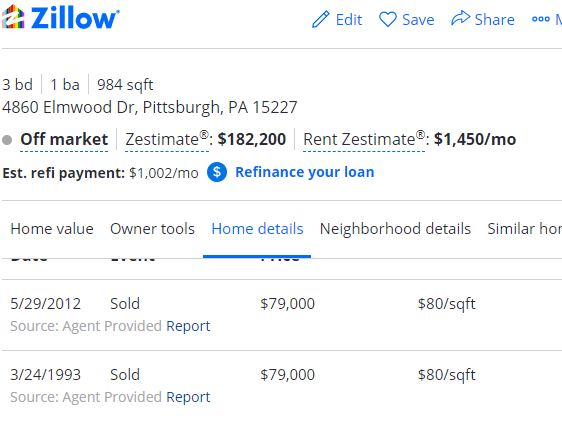

### Valid sales
  - Upon further investigation we find that most of the bad prices (Less than $10) are driven by the "LOVE&AFFECTION" category. 
  - We also find that the Sale Description has a few tags as "Valid". We filter to only use those tags going forward. 
  - We also winsorize the sales prices at +-1 % per month broken down by USEDESC

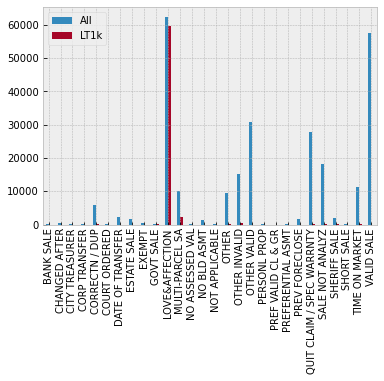

In [10]:
pd.concat([df2.groupby('SALEDESC')['SALEPRICE'].count(), df2.loc[df2.SALEPRICE < 1000].groupby('SALEDESC')['SALEPRICE'].count()],axis=1, keys = ['All','LT1k']).plot.bar()
plt.show()

In [11]:
valid_sale_codes = ['VALID SALE','OTHER VALID']
mask = [True if x in valid_sale_codes else False for x in df2['SALEDESC']]
df2 = df2.loc[mask,:]
df2['SALEPRICE_clean'] = df2.groupby(['mdate','USEDESC'])['SALEPRICE'].transform(winsorize_series,[0.01, 0.01])

### Next we create a few count plots after cleaning the prices
Note most of these plots are similar as earlier, but gives an idea of the final counts after the cleaning as been done.

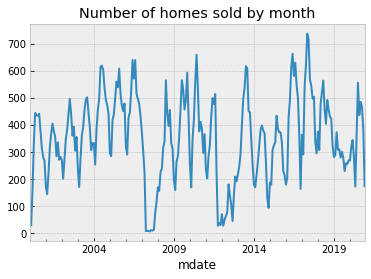

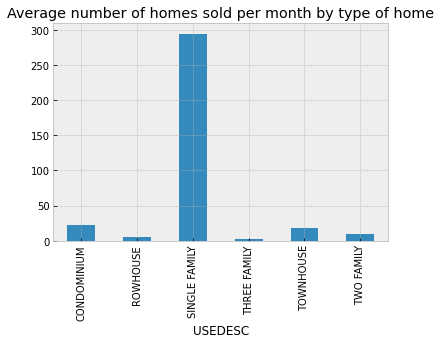

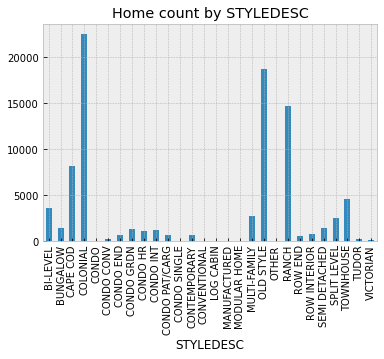

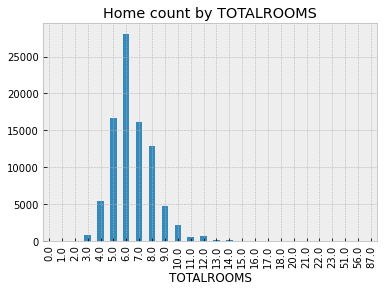

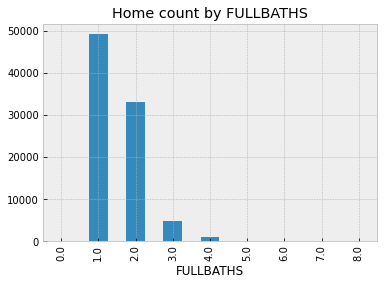

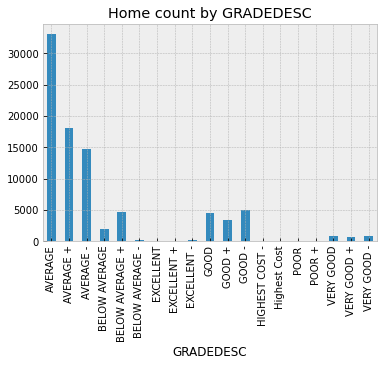

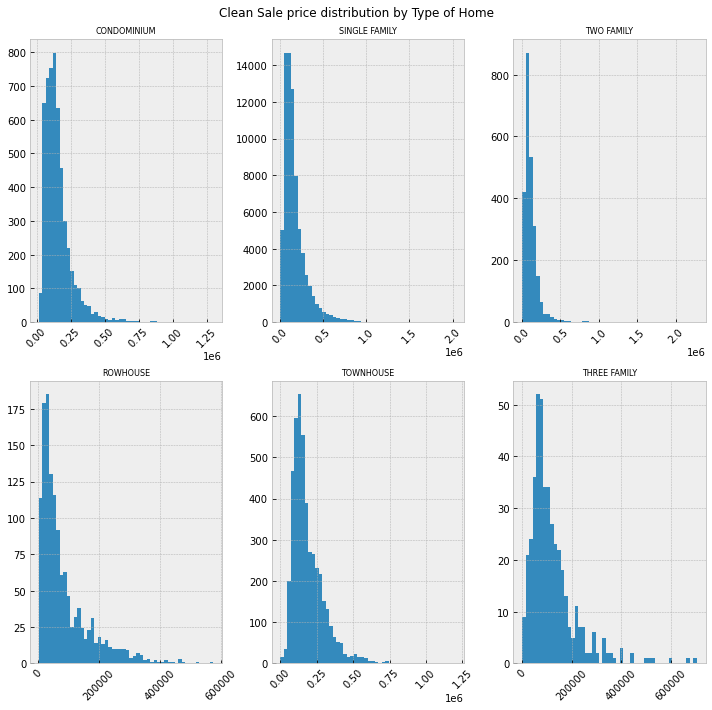

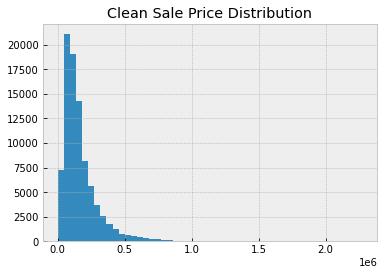

In [12]:
df2.groupby('mdate')['PARID'].count().plot()
plt.title('Number of homes sold by month')
plt.show()

df2.groupby(['mdate','USEDESC'])['SALEPRICE'].count().unstack().mean().plot.bar()
plt.title('Average number of homes sold per month by type of home')
plt.show()

df2.groupby(['STYLEDESC'])['SALEPRICE'].count().plot.bar()
plt.title('Home count by STYLEDESC')
plt.show()

df2.groupby(['TOTALROOMS'])['SALEPRICE'].count().plot.bar()
plt.title('Home count by TOTALROOMS')
plt.show()

df2.groupby(['FULLBATHS'])['SALEPRICE'].count().plot.bar()
plt.title('Home count by FULLBATHS')
plt.show()

df2.groupby(['GRADEDESC'])['SALEPRICE'].count().plot.bar()
plt.title('Home count by GRADEDESC')
plt.show()

## Price distributions

NCOLS = 3
import math
fig, axes = plt.subplots(math.ceil(len(df2.USEDESC.unique()) / NCOLS), NCOLS, figsize=(10, 10), sharex=False)
plt.suptitle('Clean Sale price distribution by Type of Home')

for idx, igroup in enumerate(df2.USEDESC.unique()):
    ax = axes[idx // NCOLS, idx % NCOLS]
    ax.hist(df2.loc[df2.USEDESC==igroup,'SALEPRICE_clean'], bins=50)
    ax.set_title(igroup, fontsize=8)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()


df2.SALEPRICE_clean.hist(bins=50)
plt.title('Clean Sale Price Distribution')
plt.show()

### Aggregate prices at cross-sectional levels
 - Ideally we would have the estimated prices of the same homes over time (similar to using Zestimate from zillow) but we do not have that granularity. So we look at aggregate prices. 
 - We also break down the prices by some characteristics such as use, total rooms, fullbaths below to get a sense of the px data.

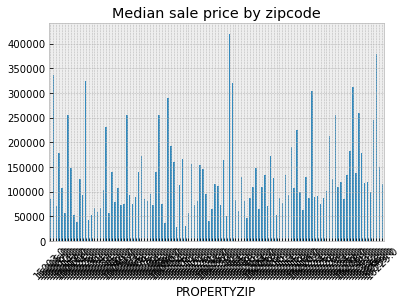

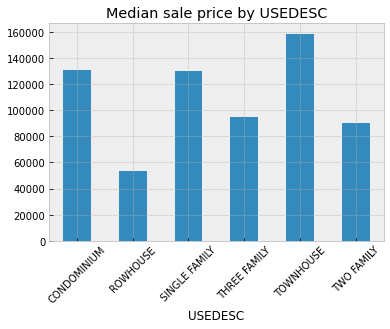

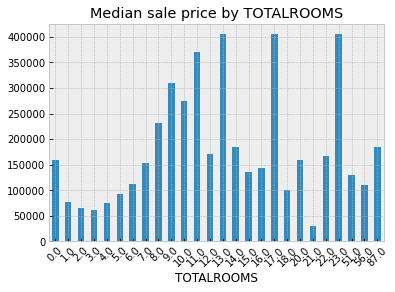

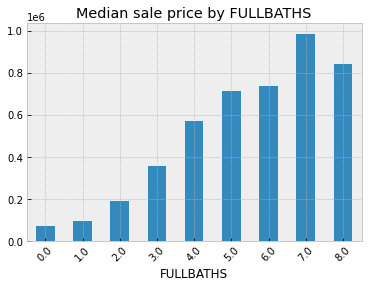

In [13]:
df2.groupby('PROPERTYZIP')['SALEPRICE_clean'].median().plot.bar()
plt.title('Median sale price by zipcode')
plt.xticks(rotation=45)
plt.show()

df2.groupby('USEDESC')['SALEPRICE_clean'].median().plot.bar()
plt.title('Median sale price by USEDESC')
plt.xticks(rotation=45)
plt.show()

df2.groupby('TOTALROOMS')['SALEPRICE_clean'].median().plot.bar()
plt.title('Median sale price by TOTALROOMS')
plt.xticks(rotation=45)
plt.show()

df2.groupby('FULLBATHS')['SALEPRICE_clean'].median().plot.bar()
plt.title('Median sale price by FULLBATHS')
plt.xticks(rotation=45)
plt.show()

### Median price over time

 - After having looked at the cross section of the prices, we now look at the time series of aggregate median prices. 

 - In the below chart we observe strong seasonality in the prices.
 - To understand this better we group by months of year and plot the median values both at aggregate levels and by house types.  - We find strong seasonality with prices being significantly higher in summer months even at aggregate levels. 

 - We also plot the yearly median prices and find that the prices have increased over time across all house types

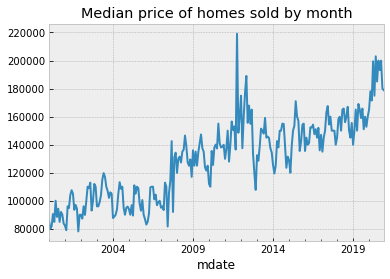

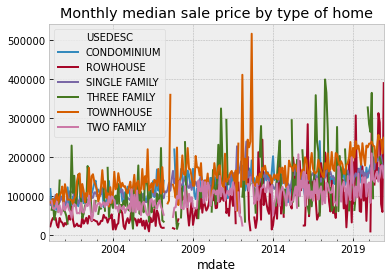

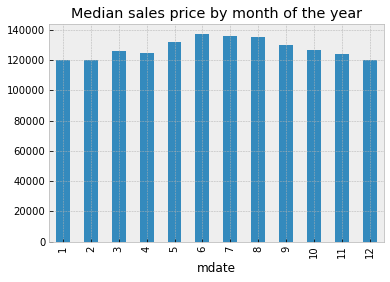

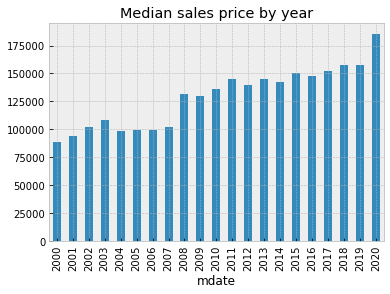

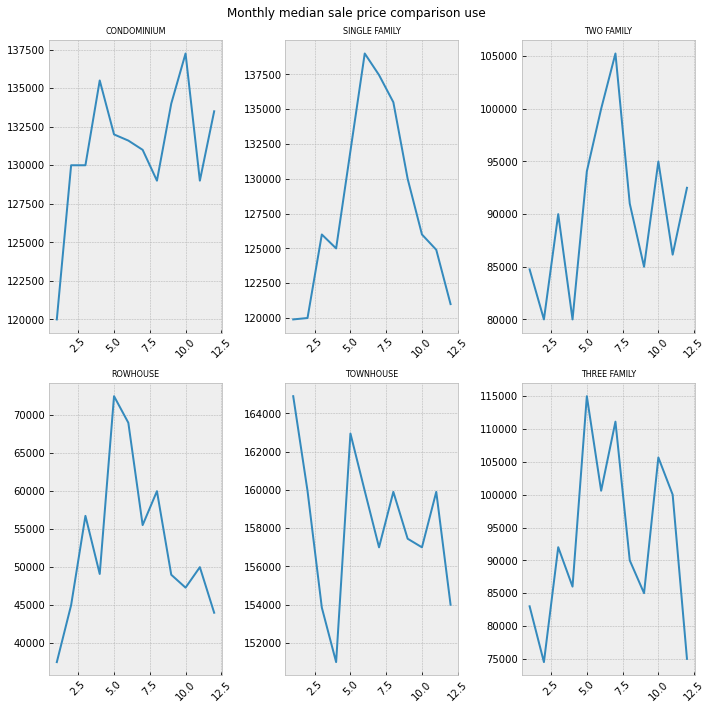

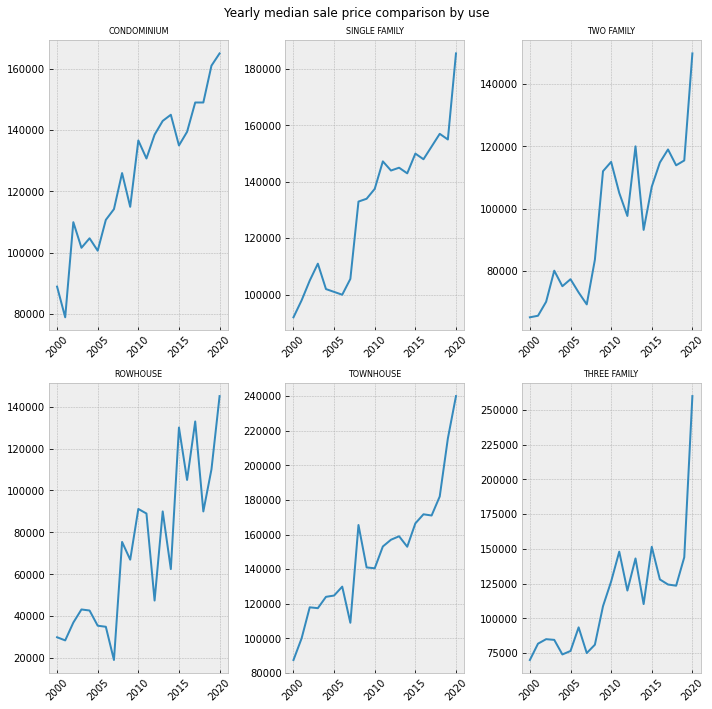

In [14]:
# Median price time series
df2.groupby('mdate')['SALEPRICE'].median().plot()
plt.title('Median price of homes sold by month')
plt.show()

# Median price time series by home type
df2.groupby(['mdate','USEDESC'])['SALEPRICE'].median().unstack().plot()
plt.title('Monthly median sale price by type of home')
plt.show()

df2['month'] = [x.month for x in df2['mdate']]
df2['year'] = [x.year for x in df2['mdate']]

# Median price by month
df2.groupby(df2.mdate.dt.month)['SALEPRICE_clean'].median().plot.bar()
plt.title('Median sales price by month of the year')
plt.show()

# Median price by year
df2.groupby(df2.mdate.dt.year)['SALEPRICE_clean'].median().plot.bar()
plt.title('Median sales price by year')
plt.show()

# Median price by month per USEDESC
NCOLS = 3
import math
fig, axes = plt.subplots(math.ceil(len(df2.USEDESC.unique()) / NCOLS), NCOLS, figsize=(10, 10), sharex=False)
plt.suptitle('Monthly median sale price comparison use')

for idx, igroup in enumerate(df2.USEDESC.unique()):
    ax = axes[idx // NCOLS, idx % NCOLS]
    ax.plot(df2.loc[df2.USEDESC==igroup,:].groupby(df2.mdate.dt.month)['SALEPRICE_clean'].median())
    ax.set_title(igroup, fontsize=8)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

# Median price by year per USEDESC
NCOLS = 3
import math
fig, axes = plt.subplots(math.ceil(len(df2.USEDESC.unique()) / NCOLS), NCOLS, figsize=(10, 10), sharex=False)
plt.suptitle('Yearly median sale price comparison by use')

for idx, igroup in enumerate(df2.USEDESC.unique()):
    ax = axes[idx // NCOLS, idx % NCOLS]
    ax.plot(df2.loc[df2.USEDESC==igroup,:].groupby(df2.mdate.dt.year)['SALEPRICE_clean'].median())
    ax.set_title(igroup, fontsize=8)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
plt.tight_layout()
plt.show()

## Question 1:

Is housing price in Allegheny county a martingale? Provide your answer using both a conceptual explanation and an empirical explanation using the case study dataset.

A martingale is defined as a sequence of random values: x0, x1, x2..xN with the property that the conditional expectation of E[x(n+1)|x0,x1..xn] is always equal to x(n). 
Hence, given a martingale, the best predictor of the value of the random variable at time t+1 is the value of the random variable at time t. 

Conceptually we do not expect the housing price to be a martingale in the real world. We do know from experience that house prices have a relatively stable drift and trend up over time. The best predictor of housing price at t+1 is not the housing price at t, but rather a function of the house price at t and the risk premia embedded in the housing market. 

We can empirically show this as well by analyzing at the housing price index created for Q2 below. Looking at the index it’s clear that the market has an average positive drift in it, thus proving that the housing price is not a martingale in the real world measure.


### Seasonalilty adjustment of prices

We found strong seasonlity in the above prices, which is a known phenomenon. To create an index we need to use a seasonally adjusted price series. 
As discussed in the shared zillow link for index creation, the seasonality is adjusted using "a LOESS-based seasonal decomposition". 


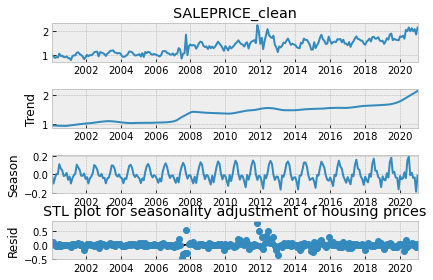

In [15]:
median_px_appreciation = df2.groupby('mdate')['SALEPRICE_clean'].mean().pct_change(1).fillna(0)

stl = STL((median_px_appreciation+1).cumprod(), seasonal=13, robust = True)
res = stl.fit()
fig = res.plot()
plt.title('STL plot for seasonality adjustment of housing prices')
plt.show()

## Question2: House price index

The house price index is basically the trend from the above median prices across the houses over time. Note we need the trend primarily to remove the seasonality and noise. In the below we show the house price index and also zoom into the housing crisis of 2008.

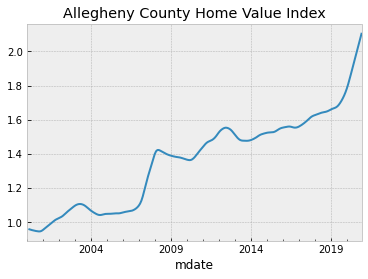

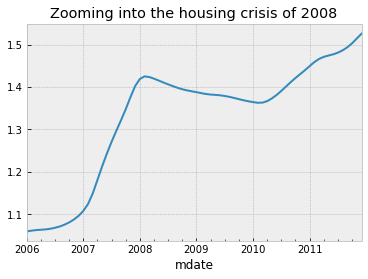

In [16]:
index = res.trend # + res.resid
index.rolling(3).mean().plot()
plt.title('Allegheny County Home Value Index')
plt.show()


res.trend.loc['2006-01-01':'2012-01-01'].plot()
plt.title('Zooming into the housing crisis of 2008')
plt.show()

### Home value index of more granual subsets. 
Given the above uses all kinds of houses sold during this period, its an aggregate. We can easily create sub-indexes using a subsets of data for different types of houses. We show some examples below:

Using the above, we can plot different breakdowns and test if a certain type of house has appreciated more over time. We notice that for example, houses with less than 5 rooms have appreciated significantly more than houses with more than 5 rooms. This also looks true intuitively. Started family homes are always more in-demand and have higher volumes. Much bigger mansions are not as widely available, are less in demand, so appreciate slower.

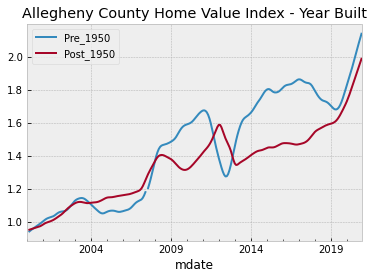

In [17]:
home_value_index_dict = {}

home_value_index_dict['Aggregate'] = index.rolling(3).mean()
home_value_index_dict['Single Family'] = create_home_value_index(df2[df2.USEDESC == 'SINGLE FAMILY'])
home_value_index_dict['Condominium'] = create_home_value_index(df2[df2.USEDESC == 'CONDOMINIUM'])
home_value_index_dict['LT_5_Rooms'] = create_home_value_index(df2[df2.TOTALROOMS < 2])
home_value_index_dict['GTE_5_Rooms'] = create_home_value_index(df2[df2.TOTALROOMS >= 2])
home_value_index_dict['Pre_1950'] = create_home_value_index(df2[df2.YEARBLT < 1950])
home_value_index_dict['Post_1950'] = create_home_value_index(df2[df2.YEARBLT >= 1950])


home_value_index_df = pd.DataFrame(home_value_index_dict)


#home_value_index_df[['Single Family', 'Condominium']].plot()
#plt.title('Allegheny County Home Value Index - Home type')
#plt.show()

#home_value_index_df[['LT_5_Rooms', 'GTE_5_Rooms']].plot()
#plt.title('Allegheny County Home Value Index - # of rooms')
#plt.show()

home_value_index_df[['Pre_1950', 'Post_1950']].plot()
plt.title('Allegheny County Home Value Index - Year Built')
plt.show()

### Investment strategy for home buying
Now for this, it would be ideal if we had point in time prices. However as we do not have that we are going to use the SALEDATE/SALEPRICE and pair with PREVSALEDATE/PREVSALEPRICE. This would give at least one total return for each house that has been sold in the past. 
We plot null values to find that PREVSALEDATE/PREVSALEPRICE has very few nulls. However PREVSALEDATE2/PREVSALEPRICE2 have a lot of nulls so we ignore those. 


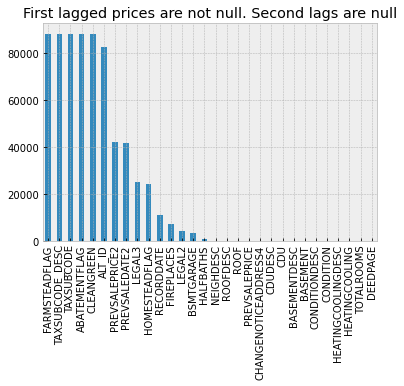

In [18]:
df2.isna().sum(0).sort_values(ascending=False)[:30].plot.bar()
plt.title('First lagged prices are not null. Second lags are null')
plt.show()

### Cleaning up Previous Sale Price. 
Similar to SalePrices, we first analyze the PrevSalePrice. We do this via following steps:

1. Compute the total appreciation as SALEPRICE_clean/prevsaleprice - 1
2. Compute # of years as the years between the two sale dates
3. Compute appreciation/year as appreciation/#of years
4. We then plot the distribution of these metrics

We take a handfull of examples from zillow show that the prices in the dataset are bad. 

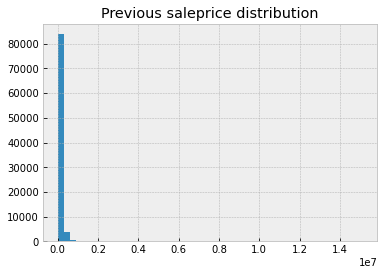

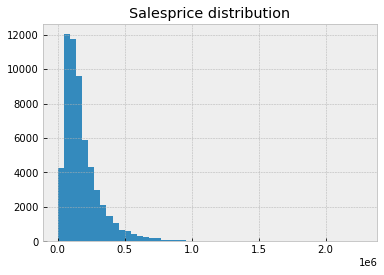

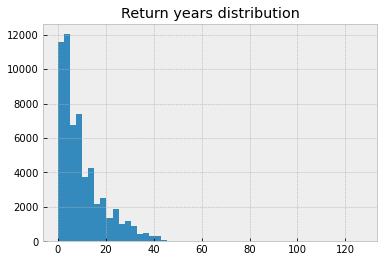

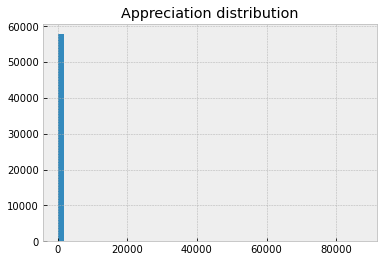

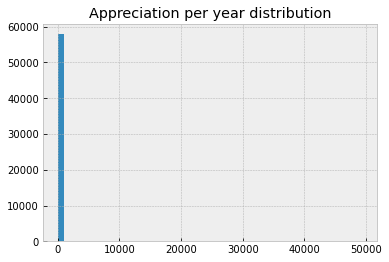

In [19]:
df2.PREVSALEPRICE.hist(bins=50)
plt.title('Previous saleprice distribution')
plt.show()

df3 = df2[df2.PREVSALEPRICE> 5]
df3['appreciation'] = df3['SALEPRICE_clean']/df3['PREVSALEPRICE'] - 1
df3['return_years'] = df3.mdate.dt.year - df3.pdate.dt.year
df3['appreciation_pyear'] = df3['appreciation']/(df3['return_years']+1)
df3 = df3[df3.return_years>=0]

df3.SALEPRICE_clean.hist(bins=50)
plt.title('Salesprice distribution')
plt.show()

df3.return_years.hist(bins=50)
plt.title('Return years distribution')
plt.show()

df3.appreciation.hist(bins=50)
plt.title('Appreciation distribution')
plt.show()

df3.appreciation_pyear.hist(bins=50)
plt.title('Appreciation per year distribution')
plt.show()

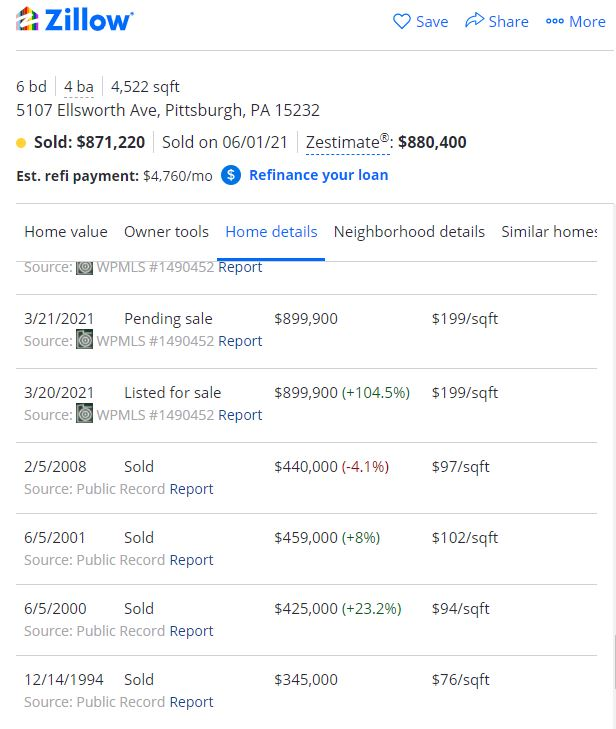

### PrevSalePrice adjustments
Looking at the previous distributions and actual zillow we know that the prices are incorrect in the data. To fix this, we follow the below steps:

1. Clip the per year appreciation to +-25%
2. Generate a "clean" total appreciation measure using the new per year appreciation metric.
3. Use the new appreciation metric to compute an adjusted PREVSALEPRICE_clean
4. Define the pnl one can generate by buying and selling this house as salespx adjusted and prev salespx adjusted

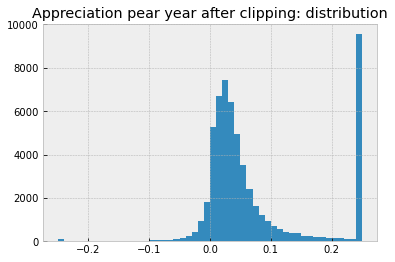

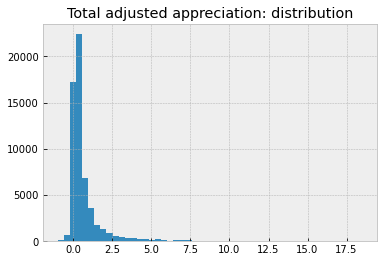

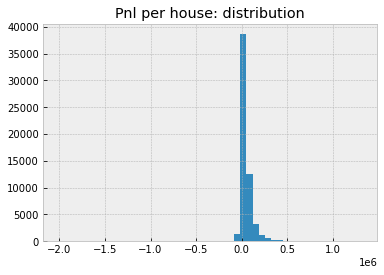

In [20]:
df3['appreciation_pyear_clipped'] = df3['appreciation_pyear'].clip(-0.25,0.25)
df3['appreciation_clean'] = df3['appreciation_pyear_clipped']*(df3['return_years']+1)

df3.appreciation_pyear_clipped.hist(bins=50)
plt.title('Appreciation pear year after clipping: distribution')
plt.show()

df3.appreciation_clean.hist(bins=50)
plt.title('Total adjusted appreciation: distribution')
plt.show()

df3['appreciationz'] = df3.groupby('pmdate')['appreciation_pyear_clipped'].transform(zscore_series,[-3,3])
df3.groupby('pmdate')['appreciation_pyear_clipped'].agg([len,np.mean, np.std,np.min,np.max,np.median])

df3['PREVSALEPRICE_clean'] = df3['SALEPRICE_clean']/(1+df3['appreciation_clean'])
df3['house_pnl'] = df3['SALEPRICE_clean'] - df3['PREVSALEPRICE_clean']

#df3.house_pnl.hist(bins=50)
#plt.title('Total adjusted appreciation: distribution')
#plt.show()

# Removing some more outliers because they do not match the actual data in zillow
df3 = df3[df3.appreciation_clean> -0.90]
df3.house_pnl.hist(bins=50)
plt.title('Pnl per house: distribution')
plt.show()

### Appreciation prediction model
For our investment model we first create a house price appreciation prediction model, which forecasts the expected appreciation of a house based on its characteristics like location, style, #of rooms etc. 
We first start with both linear and non-linear model to test which works better. We expect the non-linear model to work better. 

In [25]:
# Prediction model functions
# Function to partition dataset into test and train sets

def create_train_test_split(df, x_vars, y_var):
    df = df[x_vars+y_var]
    df = df.dropna(axis=0)
    ndata = len(df)
    trainidx = int(np.round(ndata*0.70))   
    x_train, y_train = df.iloc[:trainidx,:][x_vars],df.iloc[:trainidx,:][y_var]
    x_test, y_test = df.iloc[trainidx:,:][x_vars],df.iloc[trainidx:,:][y_var]
    return x_train, y_train, x_test, y_test

# Simple OLS regression 
def run_linear_model(x_train, y_train, x_test, y_test):
    lr = LinearRegression(normalize=False, fit_intercept = True)
    lr.fit(x_train, y_train)

    y_train_pred = lr.predict(x_train)
    y_pred = lr.predict(x_test)  

    lr_summary = {}  
    lr_summary['insample_r2'] = lr.score(x_train, y_train)
    lr_summary['outsample_r2'] = r2_score(y_test, y_pred)
    lr_summary['insample_mse'] = mean_squared_error(y_train, y_train_pred) 
    lr_summary['outsample_mse'] = mean_squared_error(y_test, y_pred) 
   
    return pd.DataFrame(lr_summary,index=[0]), pd.Series(y_pred), lr

# Ridge regression 
def run_ridge(x_train, y_train, x_test, y_test,alpha_val):
    ridge_r = Ridge(alpha=alpha_val, normalize = False, fit_intercept=True).fit(x_train, y_train)

    y_train_pred = ridge_r.predict(x_train)
    y_pred = ridge_r.predict(x_test)  

    lr_summary = {}  
    lr_summary['insample_r2'] = ridge_r.score(x_train, y_train)
    lr_summary['outsample_r2'] = r2_score(y_test, y_pred)
    lr_summary['insample_mse'] = mean_squared_error(y_train, y_train_pred) 
    lr_summary['outsample_mse'] = mean_squared_error(y_test, y_pred) 
   
    return pd.DataFrame(lr_summary,index=[0]), pd.Series(y_pred),ridge_r

# Random forest regression 
def run_rfr(x_train, y_train, x_test, y_test):
    rf = RandomForestRegressor(max_depth=3,
                               random_state=0,
                               n_estimators=200,
                               verbose=0,
                               min_samples_leaf=10,
                               max_features='sqrt',
                               n_jobs=-1)
    rf.fit(x_train, y_train)
    y_train_pred = rf.predict(x_train)
    y_pred = rf.predict(x_test)  

    lr_summary = {}  
    lr_summary['insample_r2'] = r2_score(y_train, y_train_pred)
    lr_summary['outsample_r2'] = r2_score(y_test, y_pred)
    lr_summary['insample_mse'] = mean_squared_error(y_train, y_train_pred) 
    lr_summary['outsample_mse'] = mean_squared_error(y_test, y_pred) 
    return pd.DataFrame(lr_summary,index=[0]), pd.Series(y_pred), rf

### Variables

We filter the data and extract the categorical and numerical columns that we need. 
We also drop any rows with null values at this point. Note we have already checked that none of these columns have a lot of null vaues. Otherwise we would have to 

We convert the categorical variables to one hot encoded versions. Note that there might be some multi-colinearity issues due to multiple categorical variables, however, those will only affect the coefficients and not the forecasts. 



In [22]:
categorical = ['PROPERTYZIP','USEDESC','STYLEDESC','EXTFINISH_DESC','BASEMENTDESC','GRADEDESC','HEATINGCOOLINGDESC']
numerical = ['LOTAREA','YEARBLT','TOTALROOMS','FINISHEDLIVINGAREA','mdate','appreciationz','house_pnl','pmdate','PREVSALEPRICE_clean']

df4 = df3[categorical + numerical]
df4 = df4.dropna()

for col in categorical:
    one_hot = pd.get_dummies(df4[col])#,drop_first = True)
    df4 = df4.drop(col,axis = 1)
    df4 = df4.join(one_hot, how='left', lsuffix='_left', rsuffix='_right')
    
# We create the x, y variables and train/test sets

y_var = 'appreciationz'

all_cols = df4.columns.values
x_var = list(set(all_cols) - set(['mdate','TOWNHOUSE_left', 'None_left', 'None_right', 'house_pnl','appreciationz','return_years', 'house_pnl','pmdate','PREVSALEPRICE_clean']))

print('Number of features being used: {}'.format(len(x_var)))
print('\n')
print('List of all the features')
print(x_var)

train_mask = df4.pmdate<'2016-01-01'
test_mask = df4.pmdate>='2016-01-01'

x_train, y_train =  df4.loc[train_mask,x_var] ,   df4.loc[train_mask,y_var]
x_test, y_test =  df4.loc[test_mask,x_var] ,   df4.loc[test_mask,y_var]

Number of features being used: 192


List of all the features
['ROW END', 'CONTEMPORARY', 'HIGHEST COST -', 'EXCELLENT -', 'LOG CABIN', 'CONDO CONV', 'EXCELLENT', 'Frame', 'CONDO GRDN', 'Unit Heat', 'MANUFACTURED', 'CONVENTIONAL', 'Slab/Piers', 'Highest Cost', 'MODULAR HOME', 'Electric', 'FINISHEDLIVINGAREA', 'YEARBLT', 'TWO FAMILY', 'AVERAGE -', 'Other', 'THREE FAMILY', 15003.0, 15005.0, 15006.0, 15007.0, 'Part', 'Central Heat', 15014.0, 15015.0, 'POOR', 15017.0, 15018.0, 15020.0, 16046.0, 15024.0, 15025.0, 15026.0, 15028.0, 15030.0, 15031.0, 'TOWNHOUSE_right', 15034.0, 15035.0, 16059.0, 15037.0, 15044.0, 15045.0, 15046.0, 15047.0, 15049.0, 'GOOD +', 15051.0, 'MULTI-FAMILY', 'TUDOR', 15056.0, 15057.0, 15063.0, 15064.0, 15065.0, 15068.0, 15071.0, 15075.0, 15076.0, 'Stone', 15082.0, 'Full', 15084.0, 15085.0, 15086.0, 15088.0, 15090.0, 16229.0, 'ROW INTERIOR', 'Concrete Block', 15101.0, 15102.0, 'SPLIT LEVEL', 15104.0, 'Wall Furnace with AC', 15106.0, 15108.0, 'CAPE COD', 15110.0, 'CONDO

In [46]:
df3[['TOTALROOMS','BEDROOMS','FULLBATHS','HALFBATHS','FINISHEDLIVINGAREA']].corr(method='spearman')

,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS,FINISHEDLIVINGAREA
TOTALROOMS,1.000000,0.829731,0.575279,0.378046,0.760443
BEDROOMS,0.829731,1.000000,0.527685,0.361422,0.706829
FULLBATHS,0.575279,0.527685,1.000000,0.248172,0.662413
HALFBATHS,0.378046,0.361422,0.248172,1.000000,0.426414
FINISHEDLIVINGAREA,0.760443,0.706829,0.662413,0.426414,1.000000


### Running the training models

Next we run three different models and print out their in-sample out-sample summaries. Note that these are not the final proposed models for us.

We find that the random forest model has the best outsample performance. 
Given that we expect non-linear elationships in this dataset that is not a surprise.


In [26]:
lr_summary, lr_pred, lr = run_linear_model(x_train, y_train, x_test, y_test)
rid_summary, rid_pred, ridge_lr = run_ridge(x_train, y_train, x_test, y_test,1)
rfr_summary, rfr_pred, rfr = run_rfr(x_train, y_train, x_test, y_test)

pd.concat([lr_summary,rid_summary,rfr_summary],axis=0)

,insample_r2,outsample_r2,insample_mse,outsample_mse
0,0.070785,0.004696,0.906785,0.995620
0,0.070750,0.005192,0.906818,0.995124
0,0.036385,0.032959,0.940354,0.967347


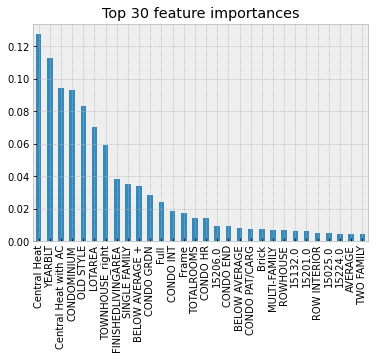

In [41]:
fi = pd.concat([pd.Series(lr.coef_), pd.Series(rfr.feature_importances_)], keys = ['lr','rfr'],axis=1)
fi.index = x_train.columns
fi.sort_values('rfr',ascending=False).head(20)

fi['rfr'].sort_values(ascending=False).head(30).plot.bar()
plt.title('Top 30 feature importances')
plt.show()

### Hyperparameter tuning of the random forest model
We created and used a basemodel for our RandomForestRegressor so far. However, for optimal performance we need to perform the hyperparameter tuning of our model. We perform the same below. Note it does take a lot of time to run this step so we show a very small subset of the grid we originally tested and used in the final model.

In [52]:
rfr_grid = RandomForestRegressor()

param_search = {
    'max_depth': [4,8,16,32],
    'max_features': [5,10,20,30],
    'min_samples_leaf': [10,20,30],
    'n_estimators': [200,300,500],
    'n_jobs' : [-1]
}

start_time =  time.time()

tscv = TimeSeriesSplit(n_splits=5)
gridsearch_rfr = GridSearchCV(estimator=rfr_grid, cv=tscv,
                          param_grid=param_search)
gridsearch_rfr.fit(x_train, y_train)

print(str(time.time() - start_time))

2829.2245445251465


### Tuned parameters performance
Next we show how the test scores differ based on the tuned hyperparameters. Note that the biggest benefits come from max_features and max_depth. Also note we have performed a grid search by pre-specifying the parameters. We could also use the RandomizedGridSearch if we do not know the range of reasonable parameters. 
We also show the best estimator from our grid search. 

Further, we use the prediction from the best model for our analysis.

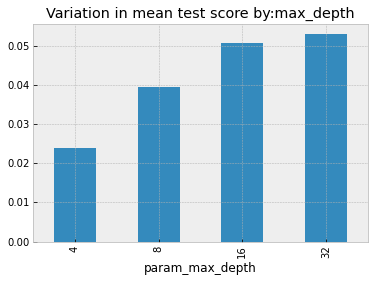

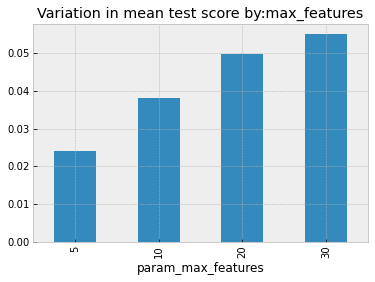

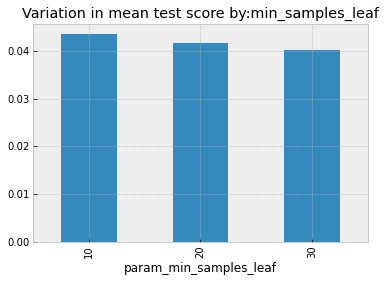

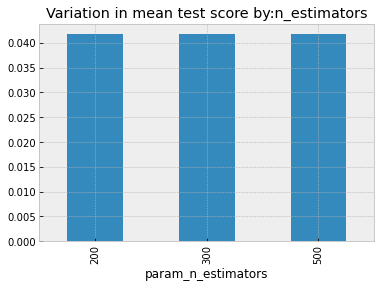

RandomForestRegressor(max_depth=16, max_features=30, min_samples_leaf=10,
                      n_estimators=500, n_jobs=-1)


In [54]:
cv_results = pd.DataFrame(gridsearch_rfr.cv_results_)
for col in ['max_depth', 'max_features', 'min_samples_leaf', 'n_estimators']:
    cv_results.groupby('param_'+col)['mean_test_score'].mean().plot.bar()
    plt.title('Variation in mean test score by:' + col)
    plt.show()
    
print(gridsearch_rfr.best_estimator_)
#rfr_pred2 = pd.Series(gridsearch_rfr.best_estimator_.predict(x_test))

### Performance of the best_estimator_ and model fitting in finance
 - In a standard machine learning processes we use the hyperparameter tuning as above and choose the best estimator in our final test model.
 - However, the downsides of an overfit model in the financial industry are significantly higher than in any other industry.    - Thus its never a good idea to blindly accept the best_estimator from a grid search style tuning approach. 
 - Further, the cross validation in finance much use time series splits due to the path dependency. 
 - In our analysis the default model which we used performs better than the optimized model. This could be due to overfitting in the max_depth and max_features parameters (comparison not shown)
 - In an ideal setting, we would spend significantly more time on this step, however given the time constraint, we continue to use the forecast from our base RFR model.

### Investment strategy.  
Once we have our prediction model, our investment strategy is simple:
1. We use the forecasted returns and buy all houses above a certain forecast threshold starting from the highest return until we exhaust the $5mn.
2. When a currently bought house is available to be sold, we sell it and record the pnl.
3. Use recycle the pnl back into our investment capital and repeat until 2015.

##### Model:
We have tested a few models and have settled on a tuned random forest regression model for our forecast. However to show that our model is actually good and outperforms the other models, we compare the performance with the linear model, and a randomly generated forecast. 

Now we can either buy at one go or buy bit by bit over time. Our predictions are basically zscores. We can come up with a rule to buy houses only over a certain score as that is our confidence interval. Note however that once we invest we cannot take the money out.
We create a function to buy any house in the market above a zcore level in the forecast. We want to plot $invested, num_houses bought and a final $amount.

##### Threshold:
Now the threshold is another hyperparameter one can choose. To keep the presentation simple and short we have excluded that analysis here. But the idea is very simple. We run the investment strategy model using RFR predictions on various thresholds and choose the best one while making sure its not datamined. For now we use the threshold to be 0.75. 
Note that the threshold does not matter too much. Supposed we chose a threshold of 0.3. What that means is we are willing to buy any house in the top 70% of the available houses per month. However, given that we have limited capital of $5mn, we generally never hit the threshold. 


                           Final NAV   #bot     pnlBooked  MeanCapRemaining
forecast_random         8.560397e+06  109.0  3.560397e+06      9.960801e+05
forecast_linear         8.825877e+06  150.0  3.825877e+06      9.025075e+05
forecast_random_forest  1.060261e+07  209.0  5.602613e+06      1.121141e+06




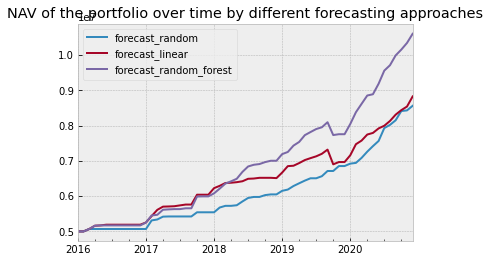

In [56]:
# The linear and RF forecasts are used in the investment model
pred_list = pd.concat([lr_pred, rfr_pred],axis=1,keys = ['forecast_linear','forecast_random_forest'])
pred_list.index = y_test.index


# Subsetting the column list and merging forecasts
col_list = ['PARID', 'PROPERTYHOUSENUM', 'PROPERTYADDRESS','PROPERTYCITY', 'PROPERTYSTATE', 'PROPERTYUNIT','SALEDATE', 'SALEPRICE', 'PREVSALEDATE',
       'PREVSALEPRICE', 'FAIRMARKETTOTAL', 'date', 'mdate','pdate','pmdate','SALEPRICE_clean', 'month', 'year', 'appreciationz', 'return_years','house_pnl','PREVSALEPRICE_clean']
df5 = pred_list.merge(df3[col_list],how='left',left_index=True, right_index=True)


# Adding a random forecast for baseline
house_df = df5.copy()
house_df['forecast_random'] = np.random.randn(len(house_df),1)

# Converting normally distributed scores to uniform distribution (percentiles)
for col in ['forecast_linear','forecast_random_forest','forecast_random']:
    house_df[col+'_pct'] = house_df.groupby('pmdate')[col].transform(percentiles)
   
    
# Running the investment strategy on the three different forecasts
nav_summary = {}
invest_summary = {}

for col in  ['forecast_random','forecast_linear','forecast_random_forest']:

    buy_threshold = 0.50 # Again this can be tuned, but performance is very robust to various thresholds.
    
    idf, inv_hc = house_buying_engine(house_df.copy(),buy_threshold, col+'_pct')
    
    # We return final NAV, total houses bought, and final pnl booked.
    invest_summary[col] = [idf.iloc[-1,-1], idf.loc[:,'houses_bought'].sum(), 
                              #idf.loc[:,'capital_invested'].sum(), 
                              idf.loc[:,'pnl_booked'].sum(), 
                              idf.loc[:,'capital_remaining'].mean()]
    nav_summary[col] =  idf['NAV']

inv_sum = pd.DataFrame(invest_summary).T
inv_sum.columns = ['Final NAV', '#bot','pnlBooked','MeanCapRemaining']
print(inv_sum)
print('\n')

pd.DataFrame(nav_summary).plot()
plt.title('NAV of the portfolio over time by different forecasting approaches')
plt.show()